## Load packages

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

C:\Users\Kelvi\AppData\Local\Temp\ipykernel_18600\3818186681.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


### Load dataset

In [3]:
df = pd.read_csv('data_cleaned.csv')

### Shuffle

In [4]:
from random import Random
df_shuffle = df.sample(frac=1, random_state=123)

### Train/test-split

In [5]:
# Import the function
from sklearn.model_selection import train_test_split

# Split of feaures and outcomes
X = df_shuffle.drop(['outcome_damage_amount'],1)
y = df_shuffle['outcome_damage_amount']

# Perform train/test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

C:\Users\Kelvi\AppData\Local\Temp\ipykernel_18600\2417780596.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_shuffle.drop(['outcome_damage_amount'],1)


### Standardise

In [6]:
from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train_stan = X_train.copy()
X_test_stan = X_test.copy()

X_train_stan[num_feat] = scaler.transform(X_train[num_feat])
X_test_stan[num_feat] = scaler.transform(X_test[num_feat])

# Linear Regression

### Train

In [7]:
from sklearn.linear_model import LinearRegression
reg= LinearRegression()
reg.fit(X_train_stan, y_train)

LinearRegression()

### Evaluate

In [8]:
predictions_train = reg.predict(X_train_stan)

+ coefficient of determination

In [9]:
print(reg.score(X_train_stan, y_train))

0.7509900324077571


+ MAE

In [10]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, predictions_train))

92.86076088612609


+ MSE

In [11]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_train, predictions_train))

35634.625021589374


# Polynomial Regression

### Cross-Validation

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

avg_scores = [None] * 3

for i in np.arange(1,4):
    
    reg_poly = Pipeline([('poly', PolynomialFeatures(degree=i)),
                  ('linear', LinearRegression(fit_intercept=False))])
    
    scores = cross_val_score(reg_poly, X_train_stan, y_train, scoring = 'r2', cv=3)
    
    avg_scores[i-1] = scores.mean()
    
    print("Order "+str(i)+": avg R^2 = "+str( avg_scores[i-1]))

Order 1: avg R^2 = -3.7010471745290504e+24
Order 2: avg R^2 = -91.69799450759928
Order 3: avg R^2 = -8.828727573929113


This are the results of the code above:
- Order 1: avg R^2 = -3.7010471745290504e+24
- Order 2: avg R^2 = -91.69799450759928
- Order 3: avg R^2 = -8.828727573929113
  
Time to train:
- Order 1: 1 second;
- Order 2: 20 seconds;
- Order 3: 5 minutes 20 seconds;

After order 3 there are to much features and the following error is produced
- numpy.core._exceptions._ArrayMemoryError: Unable to allocate 86.9 GiB for an array with shape (2638, 4421275) and data type float64

### Plot

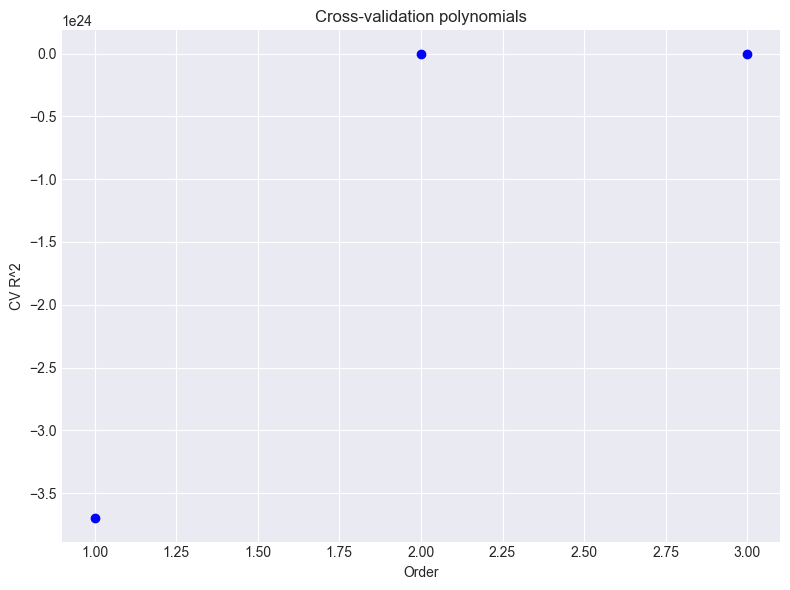

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(np.arange(1,4), avg_scores, c='b', label='data')
plt.axis('tight')
plt.title("Cross-validation polynomials")
ax.set_xlabel("Order");
ax.set_ylabel("CV R^2");
plt.tight_layout()
plt.show()

Na order 1 zien we hele grote verbeteringen maar de R^2 blijft onder nul

# Nearest Neighbors

## Radius Neighbors Regression

In [20]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import cross_val_score

Radius = np.linspace(66, 76, 10)    
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the 11 possible values for the radius (bandwith)
for k in Radius:
    Rnn = RadiusNeighborsRegressor(radius=k)
    scores = cross_val_score(Rnn, X_train_stan, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
    print("Radius " + str(k) + ": avg R^2 = " + str(scores.mean()))
    

Radius 66.0: avg R^2 = 0.0023227890860807454
Radius 67.11111111111111: avg R^2 = 0.00010710836433365234
Radius 68.22222222222223: avg R^2 = -0.0005890401515213029
Radius 69.33333333333333: avg R^2 = -0.001487060578026078
Radius 70.44444444444444: avg R^2 = -0.0014744799110497642
Radius 71.55555555555556: avg R^2 = -0.001469488995892343
Radius 72.66666666666667: avg R^2 = -0.0014668927416005672
Radius 73.77777777777777: avg R^2 = -0.0014719921444608542
Radius 74.88888888888889: avg R^2 = -0.0014733469853964731
Radius 76.0: avg R^2 = -0.0014679112559161656


66 is the lowest radius that works

### Plot

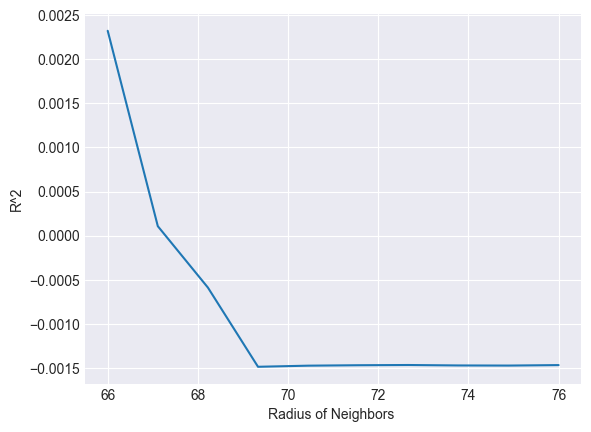

The best radius is 66.0


In [21]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(Radius, cv_scores)
plt.xlabel('Radius of Neighbors ')
plt.ylabel('R^2')

plt.show()
print('The best radius is', Radius[max_index])

## K-nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

K = np.arange(1,65)    
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwith)
for k in K:
    knn = KNeighborsRegressor(n_neighbors= k)
    scores = cross_val_score(knn, X_train_stan, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

### Plot

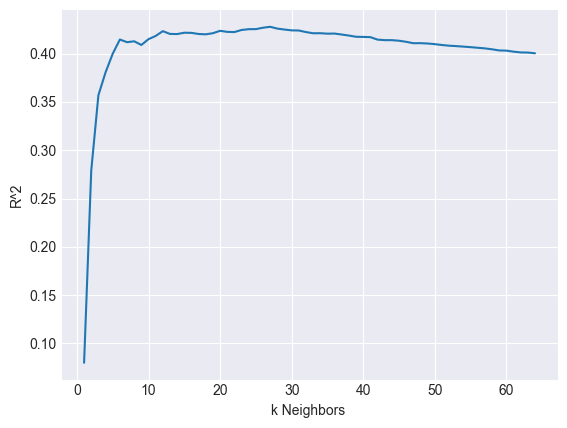

The best k is 27


In [23]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(K, cv_scores)
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')

plt.show()
print('The best k is', K[max_index])

### zoom in

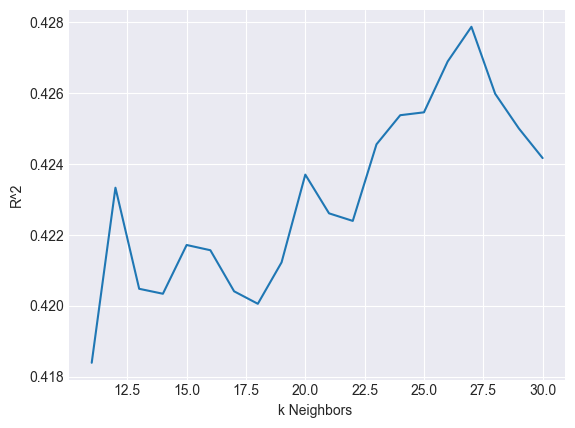

The best k is 27
The best validation score is 0.4278773356765351


In [25]:
plt.plot(K[10 : 30],cv_scores[10 :30])
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')
plt.show()
print('The best k is', K[max_index])
print('The best validation score is', max_value)

In [27]:
knn = KNeighborsRegressor(n_neighbors= 27)
knn.fit(X_train_stan, y_train)
knn.score(X_train_stan, y_train)

0.4735413095526162

## Penalisation

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_stan)
X_test_poly = poly.transform(X_test_stan)
X_train_poly.shape

lasso penalisation

In [ ]:
from sklearn import linear_model
linreg_lasso1 = linear_model.Lasso()
linreg_lasso1.fit(X_train_poly, y_train)
print('R2: %.3f' % linreg_lasso1.score(X_train_poly, y_train))

In [ ]:
# look at the coefficients (use .coef_)
linreg_lasso1.coef_

cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

Alpha = np.logspace(-3,0,10)  
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwith)
for a in Alpha:
    lasso = linear_model.Lasso(a, max_iter=5000)
    scores = cross_val_score(lasso, X_train_poly, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
 
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

train = linear_model.Lasso(Alpha[max_index], max_iter=5000)
train.fit(X_train_poly,y_train)

In [ ]:
plt.plot(Alpha, cv_scores)
plt.xlabel('alpha')
plt.ylabel('R^2')

print('The optimal alpha is', Alpha[max_index])
print('The training score of the optimal alpha is', train.score(X_train_poly,y_train))
print('The validation score of the optimal alpha is', max_value)

plt.show()

# Tree based

## Decision trees

cross validation

In [ ]:
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import cross_val_score

depth = np.arange(1,50)    # This will give an array of numbers between 1 and 10
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwith)
for d in depth:
    dec_tree = DecisionTreeRegressor(random_state = 0, max_depth=d)  
    scores = cross_val_score(dec_tree, X_train_stand, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

In [ ]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(depth, cv_scores)
plt.xlabel('depth')
plt.ylabel('R^2')

plt.show()
print('The best depth is', depth[max_index])
print('The best validation scoer is', max_value)

In [ ]:
from sklearn import tree  
dec_tree = DecisionTreeRegressor(random_state = 0, max_depth=4)  
dec_tree.fit(X_train_stand, y_train) 
print(dec_tree.score(X_train_stand, y_train) )

## Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 200)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 490)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes}

# then do cross-validatoin
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
rf_random.fit(X_train_stand, y_train)

In [ ]:
print(rf_random.score(X_train_stand, y_train))
print(rf_random.best_score_)

In [ ]:
rf_random.best_params_

In [ ]:
out = pd.DataFrame(rf_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue');
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue');
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue');
axs[2,0].set_title('criterion')

for ax in axs.flat:
    ax.set(ylabel='r_squared')